In [37]:

from src.utils import utils
from src.data.data_loading import load_articles, load_links, load_unfinished_paths, load_finished_paths, load_categories

# Imports
import pandas as pd
import numpy as np
import networkx as nx

# ----------- Statistics -------------------- #
from scipy.stats import spearmanr
from scipy.stats import linregress
# Tests
from scipy.stats import chi2_contingency

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from adjustText import adjust_text

Load necessary files for analysis

In [38]:
# Load the unfinished paths dataFrame
df_unfinished = load_unfinished_paths()

# Load the finished paths dataFrame
df_finished = load_finished_paths()

# Load the categories dataframe
df_categories = load_categories()

# Load links
df_links = load_links()

# Load articles
df_articles = load_articles()

# Correlations with quitting

## 1. Target category - Simple correlations

- We would expect the difficulty of a game to be proportional to its 'quitting' rate.

- One can infer the intrisic difficulty of a game is connected to the target article it must be reached (as well as the path connecting it to it the source article).

- Are some targets intrisically harder than others just as a function of the knowledge category the belong to?

**1.1 Correlation between target's main category, difficulty and proportion of unfinished games**

1.1.1 Computation of number of unfinished paths according to main category of target article (normalizing by total count of that target category for both unfinished and finished games)



In [39]:


# UNFINISHED PATHS
# Select 'category1' 
target_categories = df_unfinished['category1']
# len(target_categories): 29185 target articles -> 27 NaNs -> 27 articles dont have corresponding category
# Remove rows with NaN values in target_category
target_categories_unfinished = target_categories.dropna()
# Count number of known target categories for all articles in unfinished paths
target_categories_unfinished = target_categories_unfinished.value_counts()


# FINISHED PATHS
target_categories = df_finished['category1'] 
# Remove rows with NaN values in target_category
target_categories_finished = target_categories.dropna()
# Count number of known target categories for all articles in finished paths
target_categories_finished = target_categories_finished.value_counts()

# Total number of target categories for all articles
target_categories_total_count = target_categories_finished + target_categories_unfinished
# Normalize unfinished path category count by total number
target_categories_unf_norm = target_categories_unfinished/target_categories_total_count


**Results 1.1.1: Target (main) categories ordered by proportion of unfinished games**

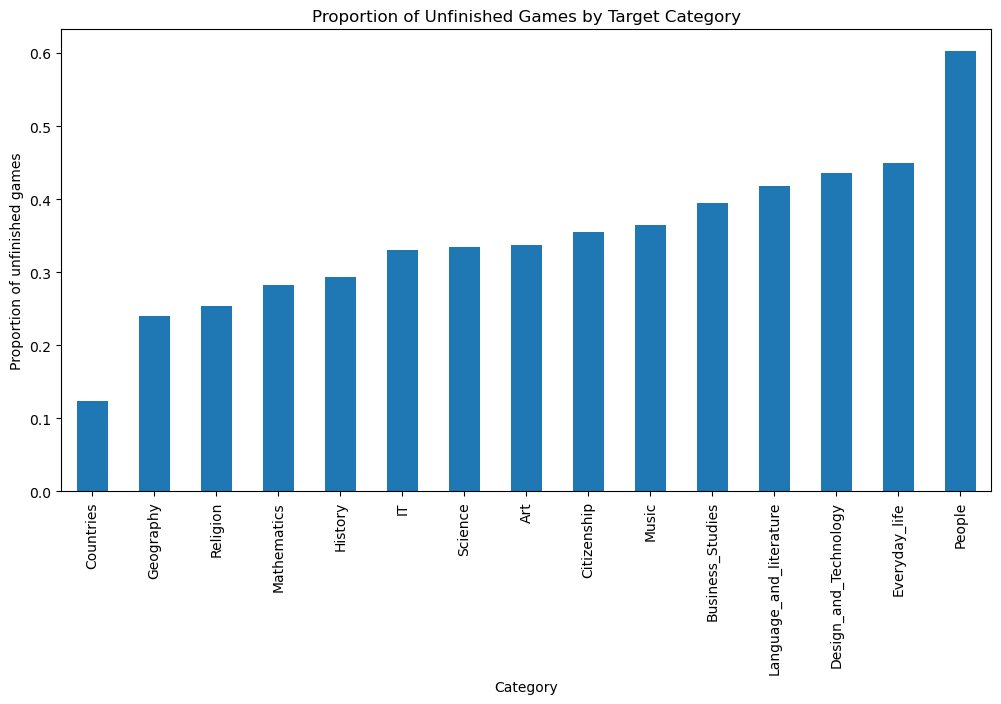

In [40]:
target_rank = target_categories_unf_norm.rank(ascending=False).sort_values()

# Bar plot for target categories
target_categories_unf_norm.sort_values().plot(kind='bar', figsize=(12, 6))
plt.title("Proportion of Unfinished Games by Target Category")
plt.xlabel("Category")
plt.ylabel("Proportion of unfinished games")
plt.show()


1.1.2 Target categories are ordered by difficulty ('rating') of finished paths 
  - Only finished games have a value for difficulty('rating') of path

In [41]:
nan_counts_all = df_finished['rating'].isna().sum()
print(f" Proportion of NaN for 'rating' column:\n {nan_counts_all/len(df_finished)*100:.2f} %")
# Drop entries (games) with no 'rating'
df_finished_categories = df_finished.dropna(subset=['rating']).reset_index(drop=True)

# Computing average 'rating' for every category
df_difficulty = df_finished [['rating','category1']]
difficulty_target = df_difficulty.groupby('category1').value_counts().unstack()
weighted_sum = (difficulty_target * difficulty_target.columns).sum(axis=1)
total_count = difficulty_target.sum(axis=1)
average_rating = weighted_sum / total_count

 Proportion of NaN for 'rating' column:
 44.46 %


**Results 1.1.2: Target (main) categories ordered by level of difficulty**

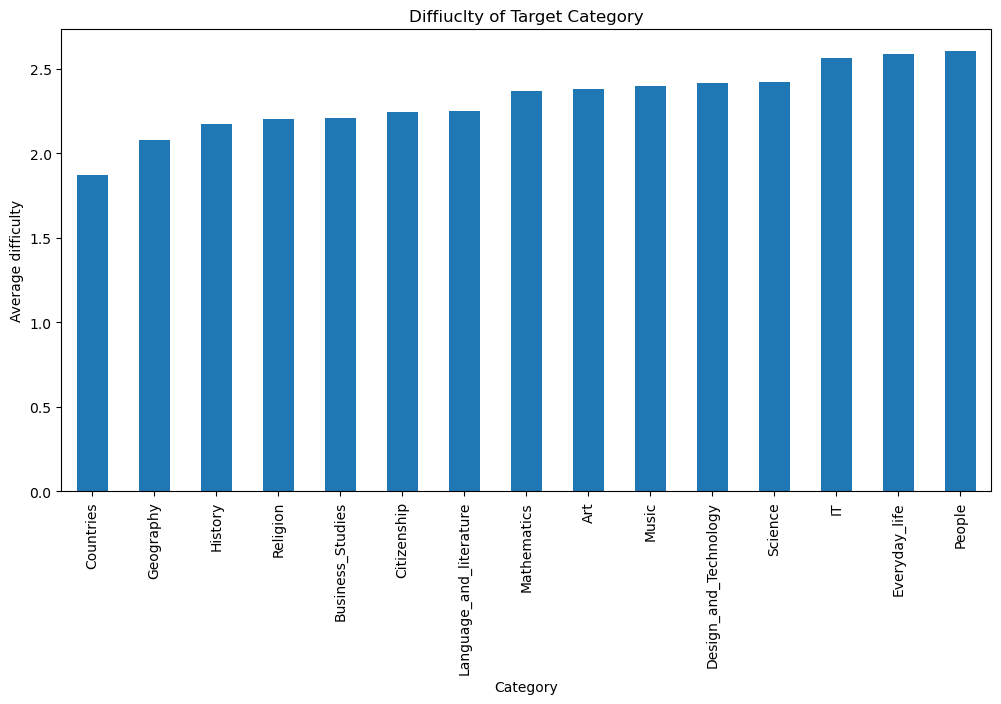

In [42]:
target_rating_rank = average_rating.rank(ascending=False).sort_values()


# Bar plot for target categories
average_rating.sort_values().plot(kind='bar', figsize=(12, 6))
plt.title("Diffiuclty of Target Category")
plt.xlabel("Category")
plt.ylabel("Average difficulty")
plt.show()

1.1.3 Merging target category average difficulty and its corresponding proportion of unfinished games
through **Spearman's coefficient for quantifying correlation and linear regression analysis for visualization**


Spearman correlation: 0.6964285714285713
P-value: 0.003921190506879554


C:\Users\beaiz\AppData\Local\Temp\ipykernel_21384\3697530586.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20', len(categories))


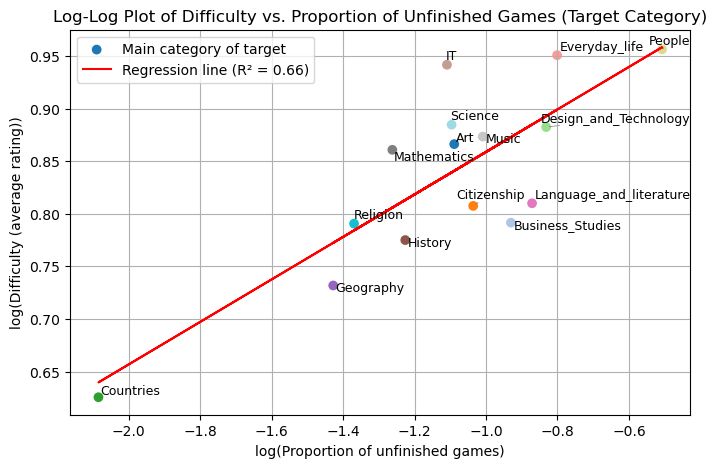

In [43]:
# I. Calculate Spearman correlation
correlation, p_value = spearmanr( target_categories_unf_norm, average_rating)

print("Spearman correlation:", correlation)
print("P-value:", p_value)


# II. Perform linear regression (with log transformation)
slope, intercept, r_value, p_value, std_err = linregress(np.log(target_categories_unf_norm), np.log(average_rating))

# Create the regression line
x_vals = np.array(np.log(target_categories_unf_norm))
y_vals_original = intercept + slope * x_vals

# Use a colormap for each category
categories = target_categories_unf_norm.index
colormap = cm.get_cmap('tab20', len(categories))
colors = {category: colormap(i) for i, category in enumerate(categories)}


# Plot
plt.figure(figsize=(8, 5))
plt.scatter(np.log(target_categories_unf_norm), np.log(average_rating),
            c=[colors[category] for category in categories], label='Main category of target')
plt.plot(x_vals, y_vals_original, color='red', label=f'Regression line (R² = {r_value**2:.2f})')


# Add labels with adjustText to avoid overlap
texts = [plt.text(x, y, category, fontsize=9) 
         for category, x, y in zip(categories, np.log(target_categories_unf_norm), np.log(average_rating))]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))


plt.xlabel('log(Proportion of unfinished games)')
plt.ylabel('log(Difficulty (average rating))')
plt.title('Log-Log Plot of Difficulty vs. Proportion of Unfinished Games (Target Category)')
plt.legend()
plt.grid(True)
plt.show()

### 1.1.4 Conclusions of correlations between target's main category, diffficulty and probability of quitting

- There seems to exist a correlation between the target's difficulty and the 'quitting' proportion:
    - The relatively high **$R^2$ value** (0.66) in the log-log model indicates a positive relationship between difficulty and proportion of unfinished games for the different topics. 
    - Similarlty,the **Spearman correlation** of 0.696 suggests a moderate positive monotonic relationship between the proportion of unfinished games and difficulty (average rating) for the different topics; the low p-value (0.0039) indicates that this correlation is statistically significant.

- The categories 'People' and 'Everyday Life' rank high in both difficulty and the proportion of unfinished games, while 'Geography' and 'Countries' rank low for bot
    - This suggests  'People' and 'Everyday Life' are intrinsically more conceptually challenging for users.
        - **'People'**
            -  'People' category, after reassigning historically significant figures to other categories like History, Science, and Art, primarily includes modern, popular figures (e.g., actors, sports figures, and media personalities).

            - If users do not have specific knowledge on these individuals it would be more challenging for them to find a path. 
            - In fact, when the analysis was repeated including historically significant figures in 'People', the difficulty and abandonment rates for 'People' were lower (mid-range).  
        - **'Everyday Life'**
           - The 'Everyday Life' category often consists of specific concepts that might not have obvious or direct connections (e.g,:'Bean'), while other topics as 'History' or 'Countries' have universally understood links (e.g., historical events, countries with neighboring borders).

    - 'Countries' and 'Geography' should be conceptually easier to navigate as logical and hierarchical connections are evident (e.g., France → Europe → Paris), users are expected to have a have basic knowledge of geography, and there are multiple connections between countries and, history and culture.

**1.2 Correlation between target's secondary category, difficulty and proportion of unfinished games**

- Analysis for top '50' secondary categories with more article counts (for unfinished and finshed paths).

- Same structure as in previous analysis

1.2.1 Top 50 secondary categories

In [44]:
# TOP SECONDARY CATEGORIES (with more counts)

# Unfinished paths
target_categories = df_unfinished['category2']
target_categories_unfinished = target_categories.dropna()
target_categories_unfinished = target_categories_unfinished.value_counts()

# Finished paths
target_categories = df_finished['category2'] 
target_categories_finished = target_categories.dropna()
target_categories_finished = target_categories_finished.value_counts()


# Total number of target categories for all articles
target_categories_total_count = target_categories_finished + target_categories_unfinished
# Get the top 50 categories in `category2` based on their counts
top_categories = (target_categories_finished + target_categories_unfinished).sort_values(ascending=False)[:50].index

# Filter the DataFrame to include only rows with `category2` in the top categories
df_target_categories_unfinished = df_unfinished[df_unfinished['category2'].isin(top_categories)]
df_target_categories_finished = df_finished[df_finished['category2'].isin(top_categories)]

# Corresponding 'category1' 
main_categories_mapping =  df_target_categories_finished[['category2', 'category1']].drop_duplicates()

1.2.2 Proportion of unfinished paths and average difficulty per secondary category

In [45]:

# ---------------- Proportion fo unfinished games ----------------- #
# Select 'category2'

# Unfinished paths
# Select 'category2'
target_categories = df_target_categories_unfinished['category2']
# len(target_categories): 29185 target articles -> 27 NaNs -> 27 articles dont have corresponding category
# Remove rows with NaN values in target_category
target_categories_unfinished = target_categories.dropna()
# Count number of known target categories for all articles in unfinished paths
target_categories_unfinished = target_categories_unfinished.value_counts()

# Finished paths
target_categories = df_target_categories_finished['category2'] 
# Remove rows with NaN values in target_category
target_categories_finished = target_categories.dropna()
# Count number of known target categories for all articles in finished paths
target_categories_finished = target_categories_finished.value_counts()


# Total number of target categories for all articles
target_categories_total_count = target_categories_finished + target_categories_unfinished
# Normalize unfinished path category count by total number
target_categories_unf_norm_2 = target_categories_unfinished/target_categories_total_count



# ------------- Average rating ------------------------- #

# Computing average 'rating' for every category
df_difficulty = df_target_categories_finished [['rating','category2']]
difficulty_target = df_difficulty.groupby('category2').value_counts().unstack()
weighted_sum = (difficulty_target * difficulty_target.columns).sum(axis=1)
total_count = difficulty_target.sum(axis=1)
average_rating_2 = weighted_sum / total_count






1.2.3 Merging average rating and proportion of unfinished paths through Spearman's correlation and linear regression

Spearman correlation: 0.6980552220888354
P-value: 1.7520740750282424e-08


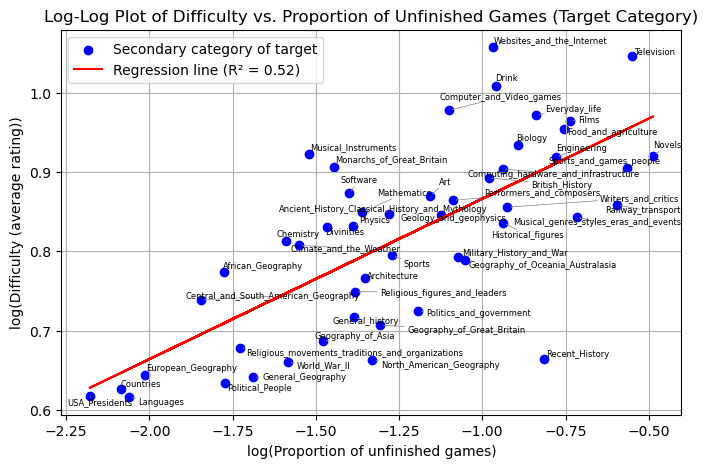

In [55]:
# I. Calculate Spearman correlation
correlation, p_value = spearmanr( target_categories_unf_norm_2, average_rating_2)

print("Spearman correlation:", correlation)
print("P-value:", p_value)


# II. Perform linear regression (with log transformation)
categories = target_categories_unf_norm_2.index
slope, intercept, r_value, p_value, std_err = linregress(np.log(target_categories_unf_norm_2), np.log(average_rating_2))

# Create the regression line
x_vals = np.array(np.log(target_categories_unf_norm_2))
y_vals_original = intercept + slope * x_vals



# Plot
plt.figure(figsize=(8, 5))
plt.scatter(np.log(target_categories_unf_norm_2), np.log(average_rating_2),
            color='blue', label='Secondary category of target')
plt.plot(x_vals, y_vals_original, color='red', label=f'Regression line (R² = {r_value**2:.2f})')


# Add labels with adjustText to avoid overlap
texts = [plt.text(x, y, category, fontsize=6) 
         for category, x, y in zip(categories, np.log(target_categories_unf_norm_2), np.log(average_rating_2))]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))


plt.xlabel('log(Proportion of unfinished games)')
plt.ylabel('log(Difficulty (average rating))')
plt.title('Log-Log Plot of Difficulty vs. Proportion of Unfinished Games (Target Category)')
plt.legend()
plt.grid(True)
plt.show()

### 1.1.4 Conclusions of correlations between target's secondary category, diffficulty and probability of quitting

- There seems to exist a correlation between the target's difficulty and the 'quitting' proportion of a path:
    - The relatively high **$R^2$ value** (0.52) in the log-log model indicates a positive relationship between difficulty and proportion of unfinished games for the different secondary topics. 
    - Similarlty,the **Spearman correlation** of 0.698 suggests a moderate positive monotonic relationship between the proportion of unfinished games and difficulty (average rating) for the different topics; the low p-value (0.1.75e-08) indicates that this correlation is statistically significant.

- Specific topics (e.g; 'Novels', 'Films', 'Railway Transport') have higher difficulty and abandonment as they might have less intuitive links with other areas of the article network; conceptually, it wouls also be more complicated to establish connections unless someone had a very specific knowledge about the topic.

- 'Countries', 'Languages', 'European Geography', and 'USA Presidents' have low difficulty ratings and quitting rates, likely because they’re widely recognized by a large portion of players. The low difficulty of 'USA Presidents' may reflect either a higher proportion of U.S. players or a universal knoweledge of U.S history.

- Some categories such as 'Recent History' and 'North American Geography' present low difficulty ratings, but higher abandonment proportions, possibly due to the presence of specific articles (more niche) that lower the average. For example, the article 'Jyllands-Posten_Muhammad_cartoons_controversy ' categorized in 'Recent History'.



## 2. Target category - Graph correlations

- Have added categories for articles with links and no category:
Articles with source link and no category
['Friend_Directdebit' 'Pikachu' 'Sponsorship_Directdebit']
Articles with target link and no category
['Directdebit' 'Pikachu' 'Friend_Directdebit']

- Some articles do not have source links although by semantic association they should.
For example, 'Osteomalacia' has no outgoing links, although it can be reached from others as 'Vitamin D'. Even though there are mentions to 'Vitamin D' in the 'Osteomalacia' article, a target link to the article is not associated:

'Chronic administration of diphenylhydantoin leading to excessive metabolism of **Vitamin D**...'

- Some articles do not have any associated link


- **Limited connections**: games does not fully capture topics connectivity.

 2.1 Graph creation 

In [59]:
# Articles as nodes; links as edges

# Reload 
df_unfinished = load_unfinished_paths()
df_finished = load_finished_paths()
df_categories = load_categories()
df_links = load_links()
df_articles = load_articles()

# Create dictionary with connections
dict_connections = {}
# Filter articles without category
articles = df_categories['article'].unique()

for article in articles:
    # Edges
    list_with_connections = df_links[df_links['linkSource']==article]['linkTarget'].unique()
    # Attributes
    main_category = df_categories[df_categories['article']==article]['category1'].values[0]
    secondary_category = df_categories[df_categories['article']==article]['category2'].values[0]
    # Dict creation
    dict_connections[article] = [list_with_connections, main_category, secondary_category]


# Initialize a graph
G = nx.DiGraph()

# Add edges from the connections dictionary
for article, characteristics_article in dict_connections.items():
    
    # Add the node with attributes
    G.add_node(article, main_category=characteristics_article[1], secondary_category=characteristics_article[2])
    # Add edges
    linked_articles = characteristics_article[0]
    for linked_article in linked_articles:
        G.add_edge(article, linked_article)

2.2 Compuation of different graph related metrics

In [60]:
# Compute metrics for all nodes
degree_centrality = nx.degree_centrality(G)
pagerank = nx.pagerank(G, alpha=0.85)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)


2.2.1 Average metrics by main topic of  article 

- Initally, analysed:  'Average Closeness Centrality', 'Average Degree Centrality', 'Average PageRank'
        'Average Betweenness Centralitty'.
- All had almost perfect linear correlation, except 'Average Closeness Centrality' 
- Hence, in order to retain the most significant information only 'Average Closeness Centrality'  and 'Average PageRank' will be included.

In [61]:
#  Dictionary for storing metrics per category
main_categories = list(df_categories['category1'].unique())
category_metrics = {}
for category in main_categories:
    # Analyse nodes by subsets determined by main category
    filtered_nodes = [node for node, attr in G.nodes(data=True) if attr.get('main_category') == category]

    # Extract metrics for filtered nodes
    category_closeness_centrality = [closeness_centrality[node] for node in filtered_nodes]
    category_pagerank = [pagerank[node] for node in filtered_nodes]
    
    # Compute average metrics
    avg_closeness = np.mean(category_closeness_centrality)
    avg_pagerank = np.mean(category_pagerank)
    
    # Add metrics to the dictionary
    category_metrics[category] = {
        'Average Closeness Centrality': avg_closeness,
        'Average PageRank': avg_pagerank
    }

# Convert the dictionary to a pandas DataFrame
df_metrics = pd.DataFrame.from_dict(category_metrics).T # Transpose so categories are rows


2.2.2 Linear regression between nodes metrics and proportion of unfinished games corresponding to category of target article

C:\Users\beaiz\AppData\Local\Temp\ipykernel_21384\2454518485.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20', len(categories))


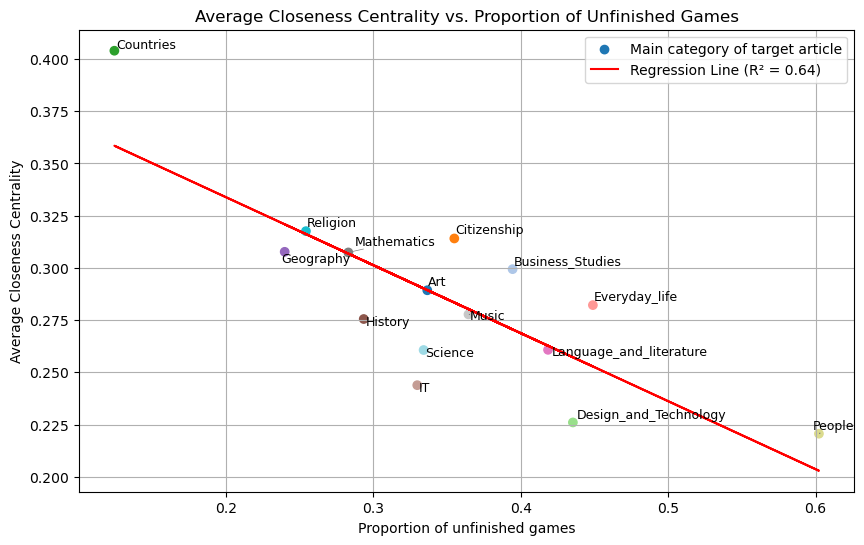

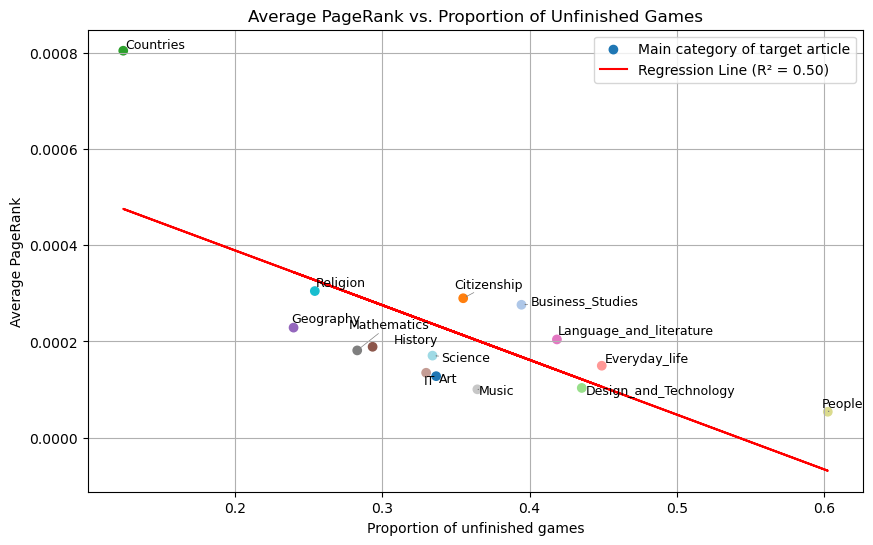

In [66]:
metrics = df_metrics.columns

for metric in metrics:
    # Otherwise not correctly aligned
    aligned_metrics = df_metrics[metric].reindex(target_categories_unf_norm.index)

    slope, intercept, r_value, p_value, std_err = linregress(target_categories_unf_norm,aligned_metrics)

    # Create the regression line
    x_vals = np.array(target_categories_unf_norm)
    y_vals_original = intercept + slope * x_vals

    # Use a colormap for each category
    categories = target_categories_unf_norm.index
    colormap = cm.get_cmap('tab20', len(categories))
    colors = {category: colormap(i) for i, category in enumerate(categories)}



    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(target_categories_unf_norm,aligned_metrics,
                c=[colors[category] for category in categories], label='Main category of target article')
    plt.plot(x_vals, y_vals_original, color='red', label=f'Regression Line (R² = {r_value**2:.2f})')


    # Add labels with adjustText to avoid overlap
    texts = [plt.text(x, y, category, fontsize=9) 
            for category, x, y in zip(categories, target_categories_unf_norm, aligned_metrics)]
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))


    plt.xlabel('Proportion of unfinished games')
    plt.ylabel(metric)
    plt.title(f'{metric} vs. Proportion of Unfinished Games')
    plt.legend()
    plt.grid(True)
    plt.show()

**2.2.3 Conclusions: correlation between the graph metrics for a given topic and the associated propotion of unfinished games for that topic (in the target)**

- Categories with high network connectivity (high centrality) , like 'Countries' and 'Geography', facilitate user navigation, decreasing abandonment. In contrast, specific categories (e.g., 'People' and 'Everyday Life') have lower connectivities, making them challenging to navigate and prone to quitting.

- Hence, the conceptual relationships inferred above between the main categories and path difficulty, are supported by the physical constraints of the network.